In [1]:
# Core
import numpy as np
import pandas as pd

# Tensorflow / ML
import tensorflow as tf
from tensorflow.python.keras import backend as K

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Utility
import os
import time

In [2]:
# Set visibible GPU
gpu_num: int = 0
os.environ['CUDA_VISIBLE_DEVICES']=f'{gpu_num}'

In [3]:
# Configure TF GPU growth
import kepler_sieve
from tf_utils import gpu_grow_memory
gpu_grow_memory(verbose=True)

Found 1 GPUs.  Setting memory growth = True.


In [4]:
# MSE Imports
from asteroid_element import load_ast_elt
from candidate_element import asteroid_elts, random_elts, elts_add_mixture_params, elts_add_H
from random_elements import best_random_elts, make_ztf_ast
from ztf_ast import load_ztf_nearest_ast, calc_hit_freq
from ztf_element import load_ztf_batch, make_ztf_batch, ztf_score_by_elt, ztf_elt_summary
from asteroid_model import AsteroidPosition, AsteroidDirection, make_model_ast_pos
from asteroid_search_layers import CandidateElements, TrajectoryScore
from asteroid_search_model import AsteroidSearchModel
from asteroid_search_report import traj_diff
from nearest_asteroid import nearest_ast_elt_cart, nearest_ast_elt_cov, elt_q_norm
from element_eda import score_by_elt
from asteroid_dataframe import calc_ast_data, spline_ast_vec_df
from astro_utils import deg2dist, dist2deg, dist2sec

In [5]:
# Aliases
keras = tf.keras

# Constants
dtype = tf.float32
dtype_np = np.float32
space_dims = 3

In [6]:
# Set plot style variables
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
mpl.rcParams['font.size'] = 16

## Load ZTF Data and Batch of Orbital Elements

In [7]:
# Load orbital elements for known asteroids
ast_elt = load_ast_elt()

# Number of asteroids
N_ast = ast_elt.shape[0]

In [8]:
# Parameters to build random orbital elements and ztf_ast
random_seed = 0
known_ast = True
batch_size_init = 1024
batch_size = 64
thresh_deg = 2.0

In [9]:
# Load ztf nearest asteroid data for known asteroids
ztf_ast = make_ztf_ast(known_ast=known_ast)

In [10]:
# Review ztf_ast
ztf_ast

,ztf_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,uz,mag_app,asteroid_prob,nearest_ast_num,nearest_ast_dist,ast_ra,ast_dec,ast_ux,ast_uy,ast_uz,is_hit
602,602,b'ZTF18acqvjbw',689314713015015008,16951,58443.314711,63.025354,17.655906,0.432230,0.899796,-0.059531,18.519199,1.000000,135355,3.663691e-06,63.025567,17.655961,0.432226,0.899798,-0.059531,True
649,649,b'ZTF18acrcadh',693308213515015017,17096,58447.308218,113.354357,33.962194,-0.328791,0.920837,0.209659,18.055201,1.000000,29076,8.997226e-07,113.354324,33.962150,-0.328790,0.920837,0.209658,True
811,811,b'ZTF18abwawbk',621435901715015019,9621,58375.435903,32.348343,11.149056,0.828867,0.558563,-0.031414,19.707199,1.000000,101787,2.084178e-06,32.348465,11.149059,0.828866,0.558565,-0.031414,True
833,833,b'ZTF18acurwxa',707509454415015012,18339,58461.509456,103.310341,27.540611,-0.204137,0.975586,0.080995,19.427401,1.000000,138763,4.068908e-06,103.310581,27.540515,-0.204141,0.975585,0.080994,True
890,890,b'ZTF18acuiphp',707257536115015009,18272,58461.257535,48.496514,22.452973,0.612431,0.786949,0.075091,19.038000,0.976392,105289,3.491132e-06,48.496726,22.453012,0.612428,0.786952,0.075091,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5697829,5697829,b'ZTF20aarepii',1151522393415015017,97090,58905.522396,236.892710,-2.341055,-0.545753,-0.784135,0.295442,15.089800,1.000000,727,2.473898e-06,236.892569,-2.341034,-0.545755,-0.784134,0.295442,True
5697832,5697832,b'ZTF20aareowa',1151522390315015003,97090,58905.522396,237.654792,-5.909325,-0.532176,-0.811960,0.239813,15.717300,1.000000,625,2.355026e-06,237.654657,-5.909328,-0.532178,-0.811958,0.239813,True
5697833,5697833,b'ZTF20aareowm',1151521944715015006,97089,58905.521944,236.239354,-9.304550,-0.548413,-0.817041,0.178007,15.695800,1.000000,464,2.205903e-06,236.239228,-9.304526,-0.548415,-0.817040,0.178007,True
5697838,5697838,b'ZTF20aareowf',1151521946215015005,97089,58905.521944,234.674482,-7.771349,-0.572910,-0.795468,0.197496,16.917900,1.000000,2879,4.163074e-06,234.674242,-7.771368,-0.572914,-0.795466,0.197494,True


In [11]:
# Best random elements
elts = best_random_elts(random_seed=random_seed, known_ast=known_ast, 
                        batch_size_init=batch_size_init, batch_size=batch_size, thresh_deg=thresh_deg)

In [12]:
# Review best random elements
elts

,element_id,a,e,f,inc,Omega,omega,epoch,num_obs,score,t_score
0,0,3.064054,0.121235,-1.291546,0.068009,0.662207,0.935398,58600.0,12711,998.002460,8.852007
1,1,2.771068,0.151421,-0.531263,0.068958,1.364763,6.111150,58600.0,11901,886.807208,8.129007
2,2,3.172947,0.095819,1.903106,0.035792,3.984825,0.687484,58600.0,12572,781.406566,6.969071
3,3,2.697356,0.098236,0.132486,0.025427,1.610715,5.259525,58600.0,9835,767.421579,7.738322
4,4,3.113809,0.257043,2.596678,0.090822,0.106255,4.320585,58600.0,9129,697.797101,7.303273
...,...,...,...,...,...,...,...,...,...,...,...
59,59,1.890665,0.083441,3.132056,0.035993,0.656159,3.255417,58600.0,9064,280.408751,2.945314
60,60,3.168699,0.088259,0.853523,0.052655,5.188591,0.902693,58600.0,10197,280.102124,2.773832
61,61,2.255124,0.055124,-1.131100,0.065725,4.743550,1.882832,58600.0,6700,279.483345,3.414432
62,62,2.325415,0.176758,-0.619556,0.046713,3.318604,2.235867,58600.0,4532,277.344008,4.119778


## Batches of ZTF Data Near Initial Candidate Elements

In [13]:
# Arguments to make_ztf_batch
near_ast = False
regenerate = False

In [14]:
# Load perturbed element batch
ztf_elt = load_ztf_batch(elts=elts, ztf=ztf_ast, thresh_deg=thresh_deg, near_ast=near_ast, regenerate=regenerate)

In [15]:
ztf_elt

,ztf_id,element_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,...,elt_ux,elt_uy,elt_uz,elt_r,s,s_sec,z,v,is_hit,is_match
0,357652,0,b'ZTF19abjggig',938492372315015003,1268,58692.492373,53.778435,17.745455,0.562794,0.826188,...,0.554305,0.832313,-0.001318,3.030342,0.026805,5529.148243,0.999641,0.589752,False,False
1,358253,0,b'ZTF19abjgfhg',938492373915015003,1268,58692.492373,53.995882,19.505049,0.554108,0.832439,...,0.554305,0.832313,-0.001318,3.030342,0.004338,894.747682,0.999991,0.015445,False,False
2,359127,0,b'ZTF19abjgfhd',938492373915015019,1268,58692.492373,53.303148,19.154581,0.564497,0.825435,...,0.554305,0.832313,-0.001318,3.030342,0.012343,2545.891323,0.999924,0.125041,False,False
3,359244,0,b'ZTF19abjgfqh',938492373315015008,1268,58692.492373,54.457412,20.235852,0.545428,0.838047,...,0.554305,0.832313,-0.001318,3.030342,0.018328,3780.523027,0.999832,0.275722,False,False
4,359275,0,b'ZTF19abjgfjl',938492371615015001,1268,58692.492373,55.224952,18.713324,0.540204,0.841398,...,0.554305,0.832313,-0.001318,3.030342,0.021711,4478.268990,0.999764,0.386885,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512300,5682027,63,b'ZTF20aarbsoy',1151130435015015008,39108,58905.130440,46.250023,14.103319,0.670669,0.739706,...,0.660978,0.749074,-0.044681,2.592171,0.017045,3515.894844,0.999855,0.238474,False,False
512301,5682059,63,b'ZTF20aarbsvt',1151130433215015003,39108,58905.130440,46.974922,12.957800,0.664943,0.742845,...,0.660978,0.749074,-0.044681,2.592171,0.033797,6971.539164,0.999429,0.937551,False,False
512302,5682122,63,b'ZTF20aarbsrh',1151130435215015007,39108,58905.130440,44.917822,15.212759,0.683306,0.729504,...,0.660978,0.749074,-0.044681,2.592171,0.033002,6807.415135,0.999455,0.893931,False,False
512303,5682133,63,b'ZTF20aarbsrx',1151130434815015006,39108,58905.130440,47.131113,15.156325,0.656659,0.753044,...,0.660978,0.749074,-0.044681,2.592171,0.006666,1374.963549,0.999978,0.036472,False,False


In [16]:
# Score by element
score_by_elt = ztf_score_by_elt(ztf_elt)

In [17]:
# Mixture parameters
num_hits: int = 10
R_deg: float = 0.5

In [18]:
# Add mixture parameters to candidate elements
elts_add_mixture_params(elts=elts, num_hits=num_hits, thresh_deg=thresh_deg, R_deg=R_deg)

In [19]:
# Add brightness parameter H
elts_add_H(elts=elts)

In [20]:
# Summarize the ztf element batch: perturbed asteroids
ztf_elt_summary(ztf_elt, score_by_elt, 'Random Elements')

ZTF Element Dataframe Random Elements:
                  Total     (Per Batch)
Observations   :   512305   (     8005)

Summarize score = sum(-1.0 - log(v)) by batch.  (Mean=0, Variance=num_obs)
Mean score     :     442.59
Sqrt(batch_obs):      89.47
Mean t_score   :       5.11


In [21]:
# Review random elements
elts

,element_id,a,e,f,inc,Omega,omega,epoch,num_obs,score,t_score,num_hits,R,thresh_s,H,sigma_mag
0,0,3.064054,0.121235,-1.291546,0.068009,0.662207,0.935398,58600.0,12711,998.002460,8.852007,10,0.008727,0.034905,16.5,4.0
1,1,2.771068,0.151421,-0.531263,0.068958,1.364763,6.111150,58600.0,11901,886.807208,8.129007,10,0.008727,0.034905,16.5,4.0
2,2,3.172947,0.095819,1.903106,0.035792,3.984825,0.687484,58600.0,12572,781.406566,6.969071,10,0.008727,0.034905,16.5,4.0
3,3,2.697356,0.098236,0.132486,0.025427,1.610715,5.259525,58600.0,9835,767.421579,7.738322,10,0.008727,0.034905,16.5,4.0
4,4,3.113809,0.257043,2.596678,0.090822,0.106255,4.320585,58600.0,9129,697.797101,7.303273,10,0.008727,0.034905,16.5,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,59,1.890665,0.083441,3.132056,0.035993,0.656159,3.255417,58600.0,9064,280.408751,2.945314,10,0.008727,0.034905,16.5,4.0
60,60,3.168699,0.088259,0.853523,0.052655,5.188591,0.902693,58600.0,10197,280.102124,2.773832,10,0.008727,0.034905,16.5,4.0
61,61,2.255124,0.055124,-1.131100,0.065725,4.743550,1.882832,58600.0,6700,279.483345,3.414432,10,0.008727,0.034905,16.5,4.0
62,62,2.325415,0.176758,-0.619556,0.046713,3.318604,2.235867,58600.0,4532,277.344008,4.119778,10,0.008727,0.034905,16.5,4.0


## Build Asteroid Search Model

In [22]:
# Observatory for ZTF data is Palomar Mountain
site_name = 'palomar'

In [23]:
# Training parameters
learning_rate = 2.0**-12
clipnorm = 1.0

In [24]:
# Build asteroid search model
model = AsteroidSearchModel(
                elts=elts, ztf_elt=ztf_elt, 
                site_name=site_name, thresh_deg=thresh_deg, 
                learning_rate=learning_rate, clipnorm=clipnorm,
                file_name=f'candidate_elt_rand_known_{random_seed:04d}.h5',
                name='model')

In [25]:
# Report before training starts
model.report()


Good elements (hits >= 10):   0.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:      nan  :    nan :      nan :      nan
Mean Bad :     1.03  :   0.00 :  1793.72 :  7200.00
Mean     :     1.03  :   0.00 :  1793.72 :  7200.00
Median   :     0.96  :   0.00 :  1792.82 :  7200.00
GeoMean  :     1.17  :   0.00 :  1793.71 :  7200.99
Min      :     0.24  :   0.00 :  1792.82 :  7200.00
Max      :     2.65  :   0.00 :  1807.21 :  7200.00
Trained for 0 batches over 0 epochs and 0 episodes (elapsed time 0 seconds).


/home/michael/anaconda3/envs/kepler/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/michael/anaconda3/envs/kepler/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [26]:
# model.load()

In [27]:
model.report()


Good elements (hits >= 10):   0.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:      nan  :    nan :      nan :      nan
Mean Bad :     1.03  :   0.00 :  1793.72 :  7200.00
Mean     :     1.03  :   0.00 :  1793.72 :  7200.00
Median   :     0.96  :   0.00 :  1792.82 :  7200.00
GeoMean  :     1.17  :   0.00 :  1793.71 :  7200.99
Min      :     0.24  :   0.00 :  1792.82 :  7200.00
Max      :     2.65  :   0.00 :  1807.21 :  7200.00
Trained for 0 batches over 0 epochs and 0 episodes (elapsed time 0 seconds).


In [28]:
# raise ValueError

## Automated Training with Sieve Method


********************************************************************************
Round 1: 512 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 7200.0
********************************************************************************

Training episode 0: Epoch    0, Batch      0
effective_learning_rate=2.441e-04, training_time 0 sec.
Train on 4096 samples
Epoch 1/4
4096/4096 [==============================] - 4s 877us/sample - loss: -157993.9980
Epoch 2/4
4096/4096 [==============================] - 2s 388us/sample - loss: -210176.0049
Epoch 3/4
4096/4096 [==============================] - 2s 379us/sample - loss: -278879.8228
Epoch 4/4
4096/4096 [==============================] - 2s 372us/sample - loss: -369309.4736
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:   1098.50 :  1098.50 :      nan arc seconds
Geom Mean Threshold :   7200.00 :  7200.00 :      nan arc seconds
Mean Log Likelihood :      2.26 :     2.26 :      nan
Mean Hits           :      

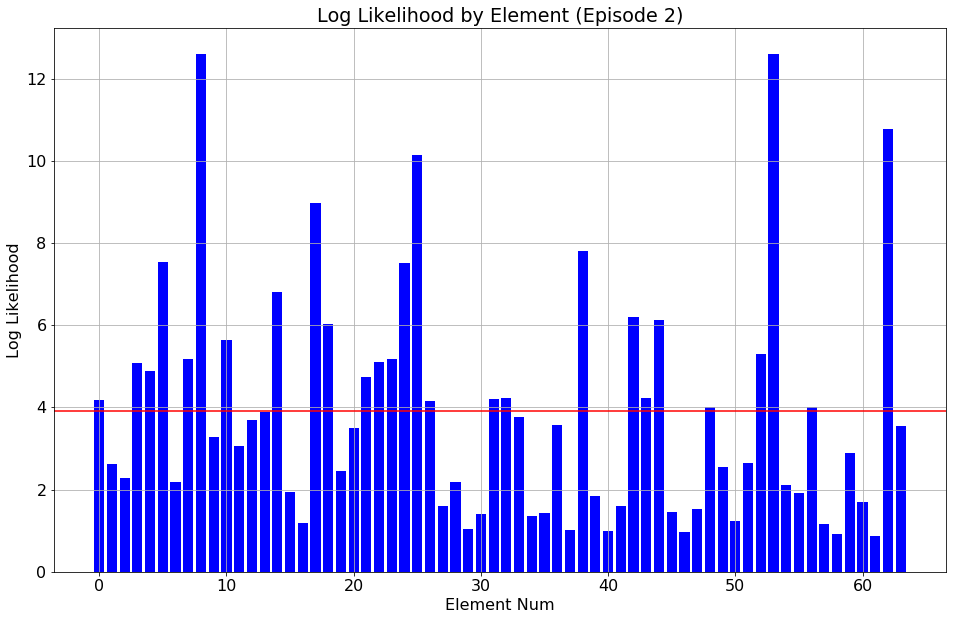

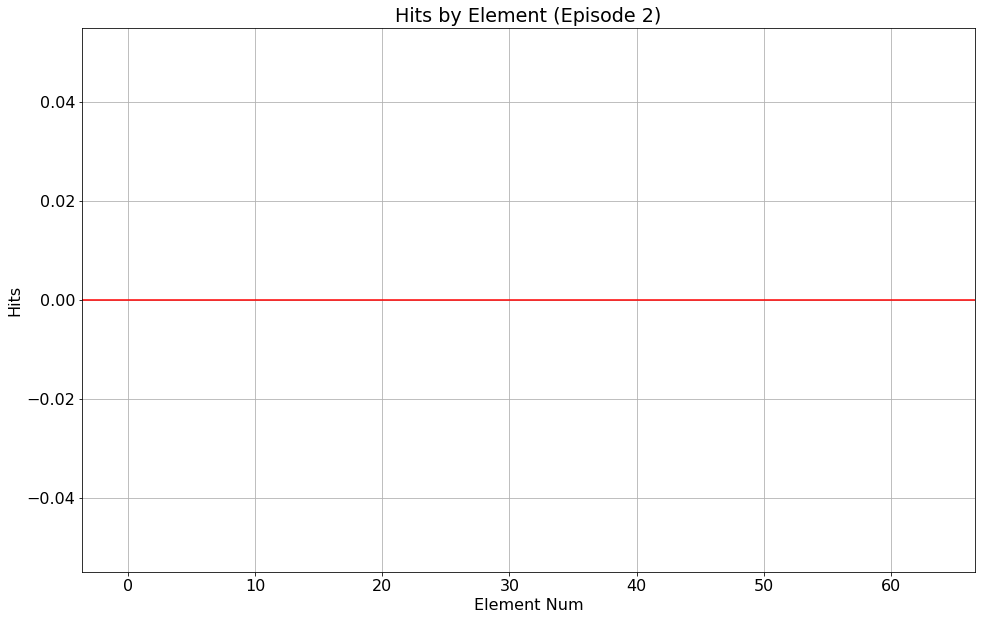


********************************************************************************
Round 2: 2048 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 2: Epoch    8, Batch    512
effective_learning_rate=2.441e-04, training_time 24 sec.
Train on 4096 samples
Epoch 9/12
4096/4096 [==============================] - 5s 1ms/sample - loss: -596.5260
Epoch 10/12
4096/4096 [==============================] - 2s 471us/sample - loss: -749.9319
Epoch 11/12
4096/4096 [==============================] - 2s 468us/sample - loss: -809.3610
Epoch 12/12
4096/4096 [==============================] - 2s 469us/sample - loss: -847.3682
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    755.17 :   755.17 :      nan arc seconds
Geom Mean Threshold :   7200.00 :  7200.00 :      nan arc seconds
Mean Log Likelihood :     13.49 :    13.49 : 

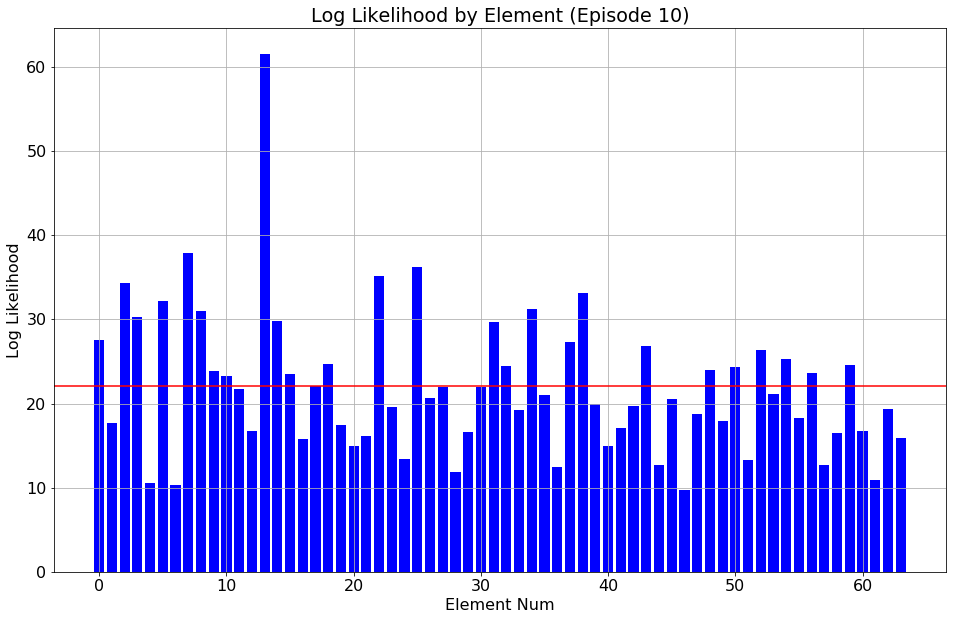

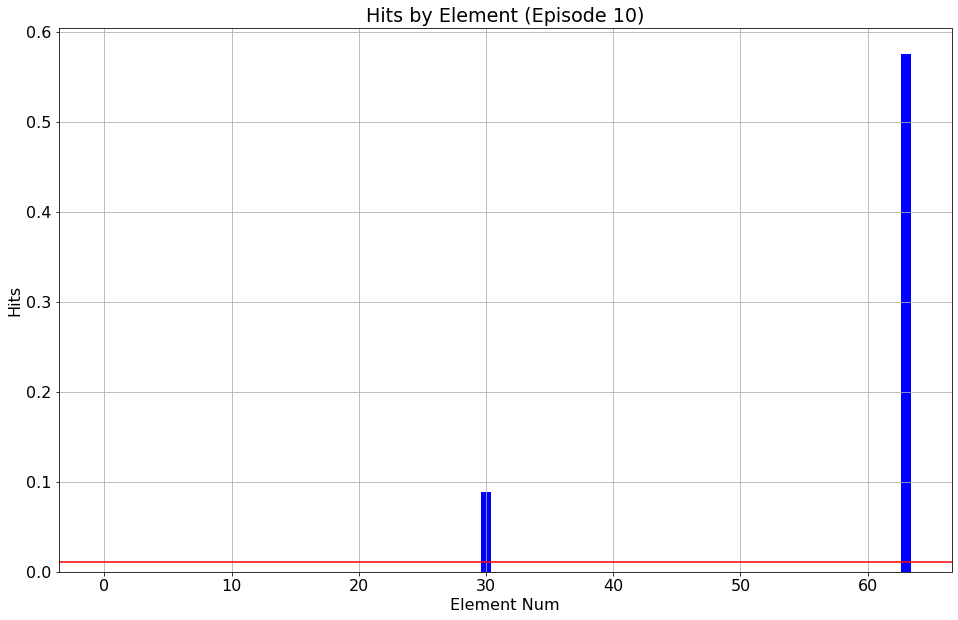


********************************************************************************
Round 3: 512 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 5400.0
********************************************************************************

Training episode 10: Epoch   40, Batch   2560
effective_learning_rate=2.441e-04, training_time 103 sec.
Train on 4096 samples
Epoch 41/44
4096/4096 [==============================] - 3s 853us/sample - loss: -5317710.2266
Epoch 42/44
4096/4096 [==============================] - 2s 398us/sample - loss: -6311470.2891
Epoch 43/44
4096/4096 [==============================] - 2s 412us/sample - loss: -7304659.9844
Epoch 44/44
4096/4096 [==============================] - 2s 407us/sample - loss: -8251905.8984
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    384.68 :   384.68 :      nan arc seconds
Geom Mean Threshold :   5400.00 :  5400.00 :      nan arc seconds
Mean Log Likelihood :     23.32 :    23.32 :      nan
Mean Hits   

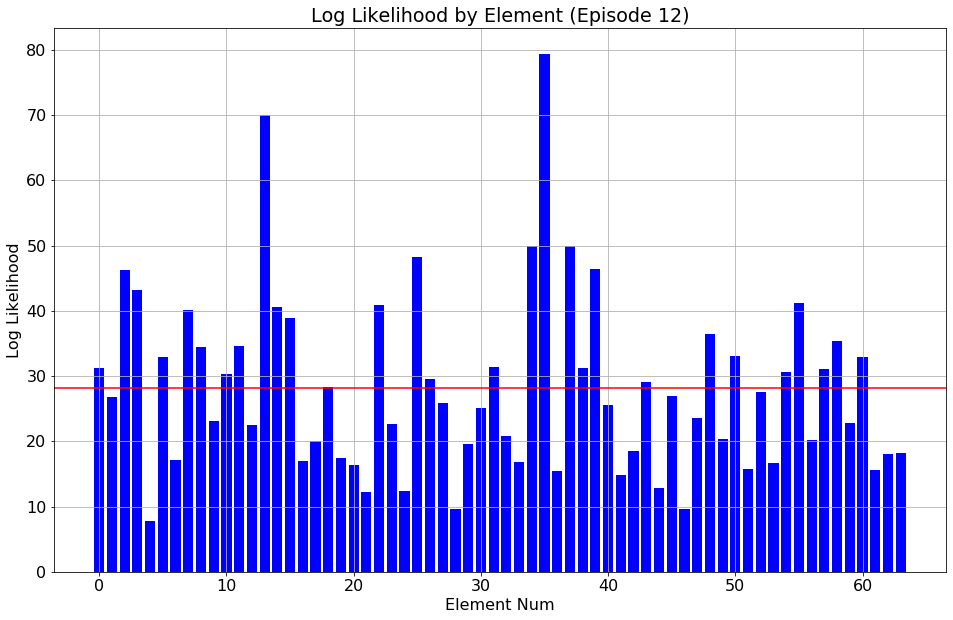

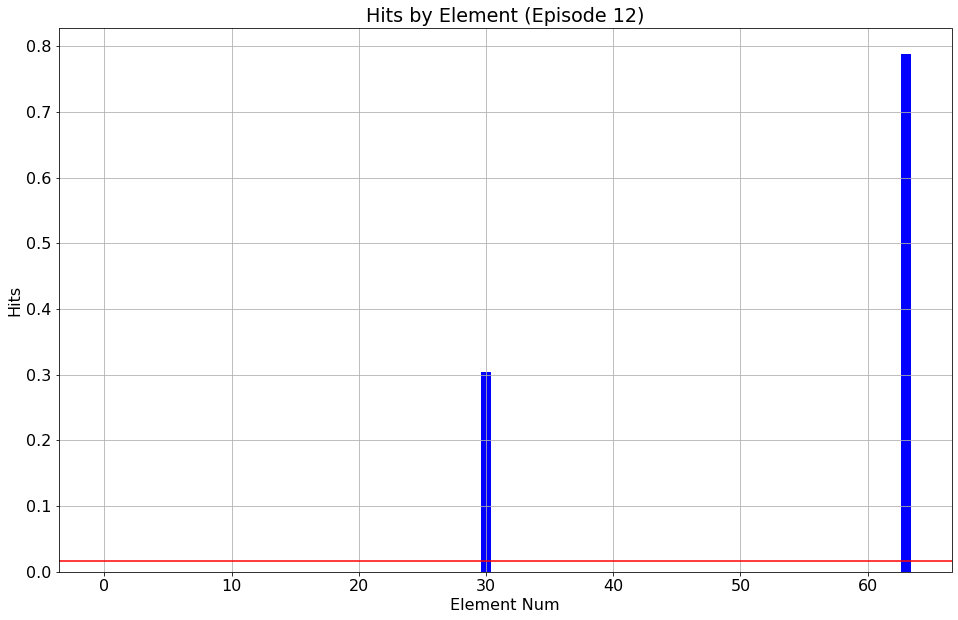


********************************************************************************
Round 4: 2048 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 12: Epoch   48, Batch   3072
effective_learning_rate=2.365e-04, training_time 121 sec.
Train on 4096 samples
Epoch 49/52
4096/4096 [==============================] - 5s 1ms/sample - loss: -1910.0923
Epoch 50/52
4096/4096 [==============================] - 2s 495us/sample - loss: -1973.3904
Epoch 51/52
4096/4096 [==============================] - 2s 504us/sample - loss: -2010.8400
Epoch 52/52
4096/4096 [==============================] - 2s 514us/sample - loss: -2040.4858
Adjusted element weight down on 1 candidate elements. Mean weight = 9.92e-01
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    325.36 :   325.36 :      nan arc seconds
Geom Mean Threshold :   540

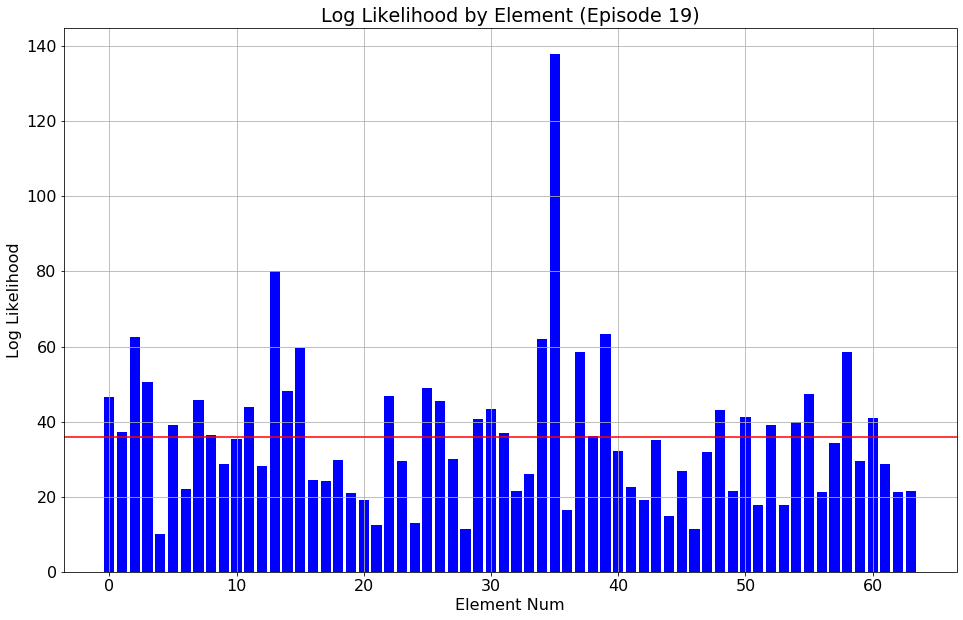

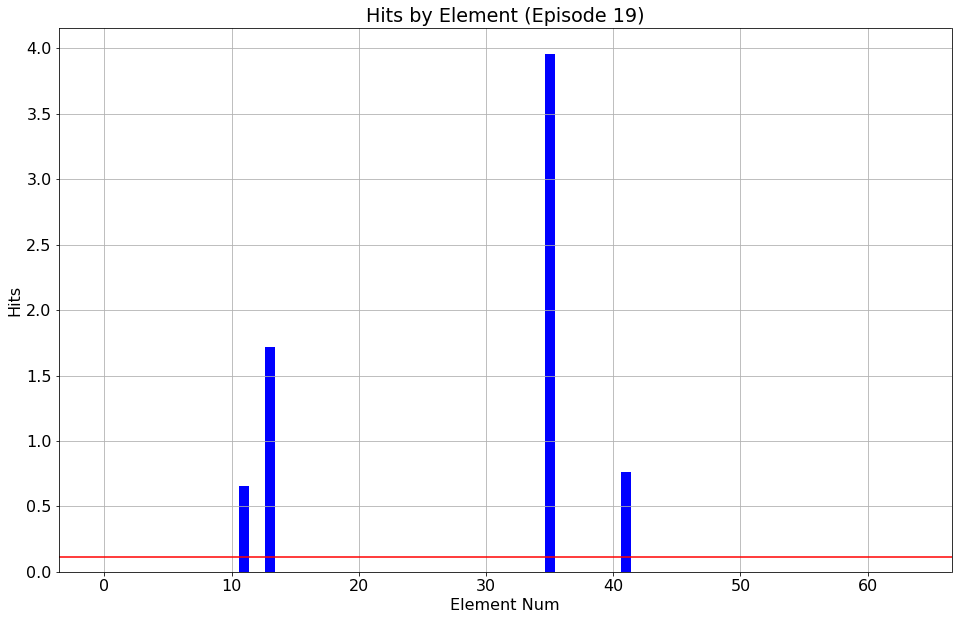


********************************************************************************
Round 5: 512 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 3600.0
********************************************************************************

Training episode 19: Epoch   76, Batch   4864
effective_learning_rate=2.441e-04, training_time 195 sec.
Train on 4096 samples
Epoch 77/80
4096/4096 [==============================] - 3s 846us/sample - loss: -17451542.7188
Epoch 78/80
4096/4096 [==============================] - 2s 430us/sample - loss: -18413557.8125
Epoch 79/80
4096/4096 [==============================] - 2s 419us/sample - loss: -19105364.2188
Epoch 80/80
4096/4096 [==============================] - 2s 421us/sample - loss: -19641800.5625
Adjusted element weight down on 12 candidate elements. Mean weight = 9.06e-01
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    257.80 :   257.80 :      nan arc seconds
Geom Mean Threshold :   3600.00 :  3600.00 :      

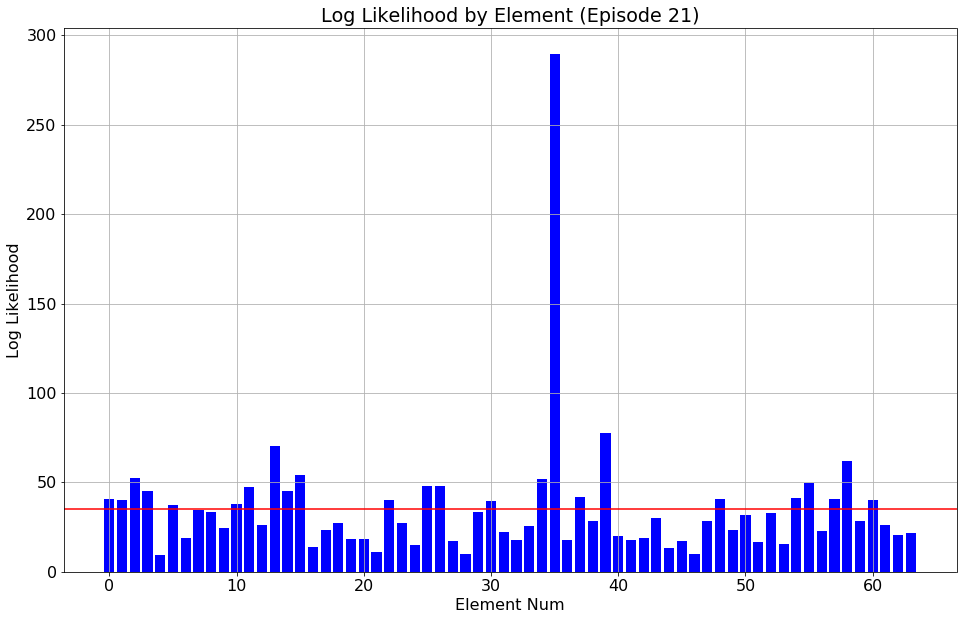

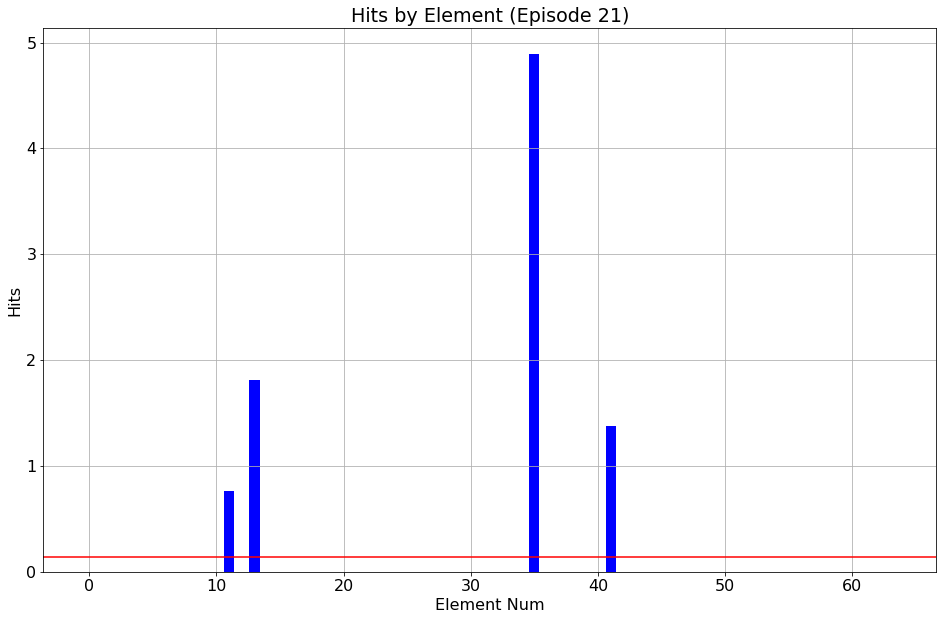


********************************************************************************
Round 6: 2048 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 21: Epoch   84, Batch   5376
effective_learning_rate=1.764e-04, training_time 214 sec.
Train on 4096 samples
Epoch 85/88
4096/4096 [==============================] - 5s 1ms/sample - loss: -1824.0728
Epoch 86/88
4096/4096 [==============================] - 2s 552us/sample - loss: -1850.6210
Epoch 87/88
4096/4096 [==============================] - 2s 539us/sample - loss: -1859.7363
Epoch 88/88
4096/4096 [==============================] - 2s 547us/sample - loss: -1867.6918
Adjusted element weight down on 64 candidate elements. Mean weight = 6.11e-02
Increasing bad_episode_count to 1.
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    253.03 :   253.03 :      nan arc

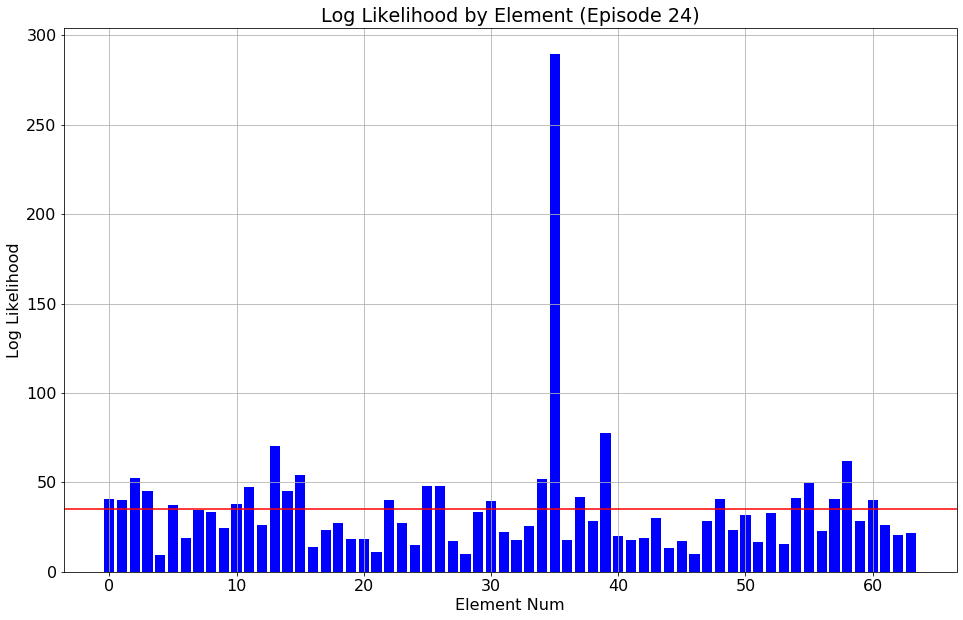

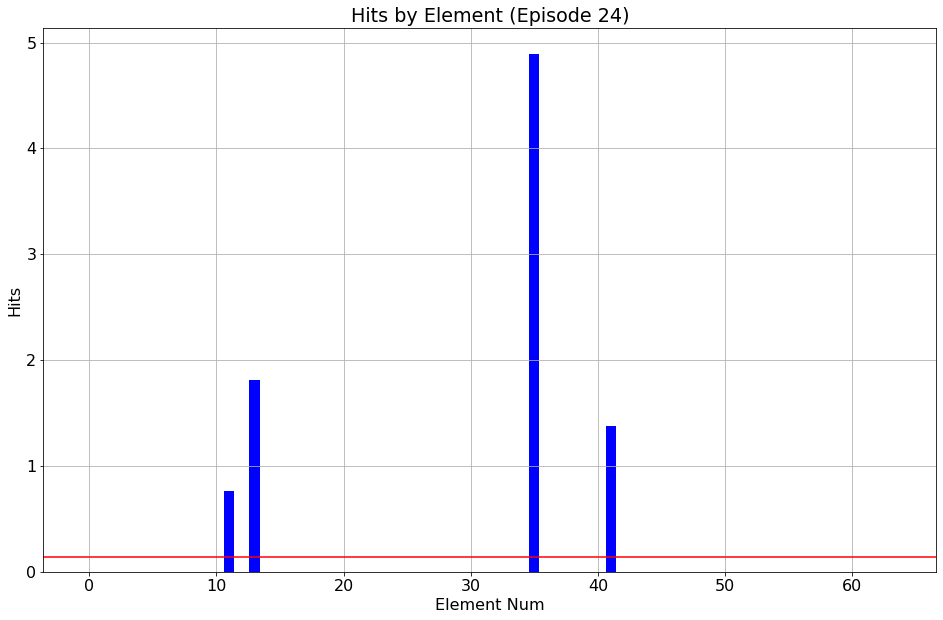


********************************************************************************
Round 7: 512 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 2400.0
********************************************************************************

Training episode 24: Epoch   96, Batch   6144
effective_learning_rate=2.441e-04, training_time 249 sec.
Train on 4096 samples
Epoch 97/100
4096/4096 [==============================] - 3s 799us/sample - loss: -25816795.6562
Epoch 98/100
4096/4096 [==============================] - 2s 460us/sample - loss: -26626322.5625
Epoch 99/100
4096/4096 [==============================] - 2s 450us/sample - loss: -27442640.7812
Epoch 100/100
4096/4096 [==============================] - 2s 464us/sample - loss: -28340764.3438
Adjusted element weight down on 43 candidate elements. Mean weight = 6.64e-01
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    247.60 :   247.60 :      nan arc seconds
Geom Mean Threshold :   2383.20 :  2383.20 : 

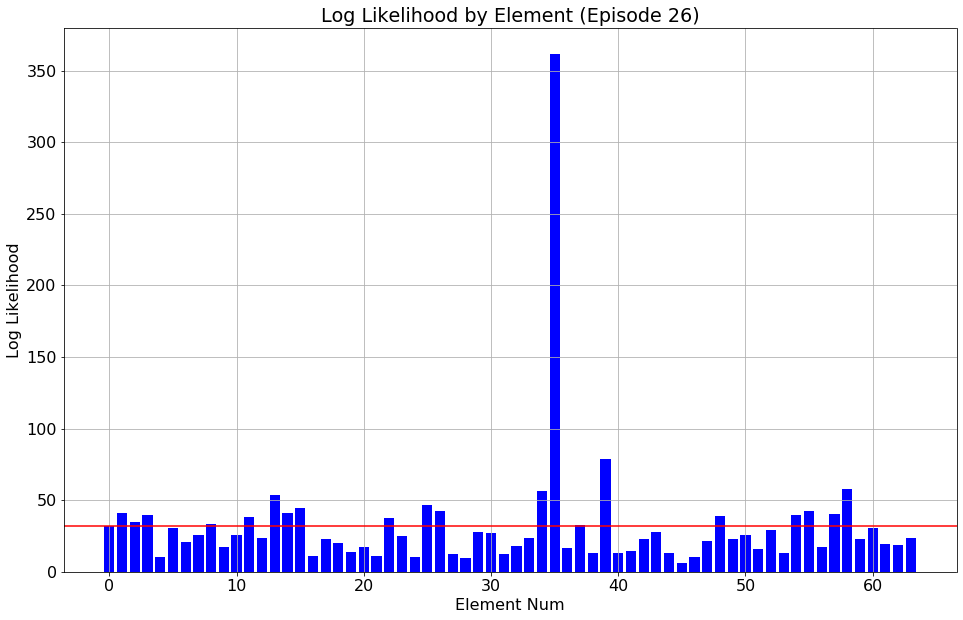

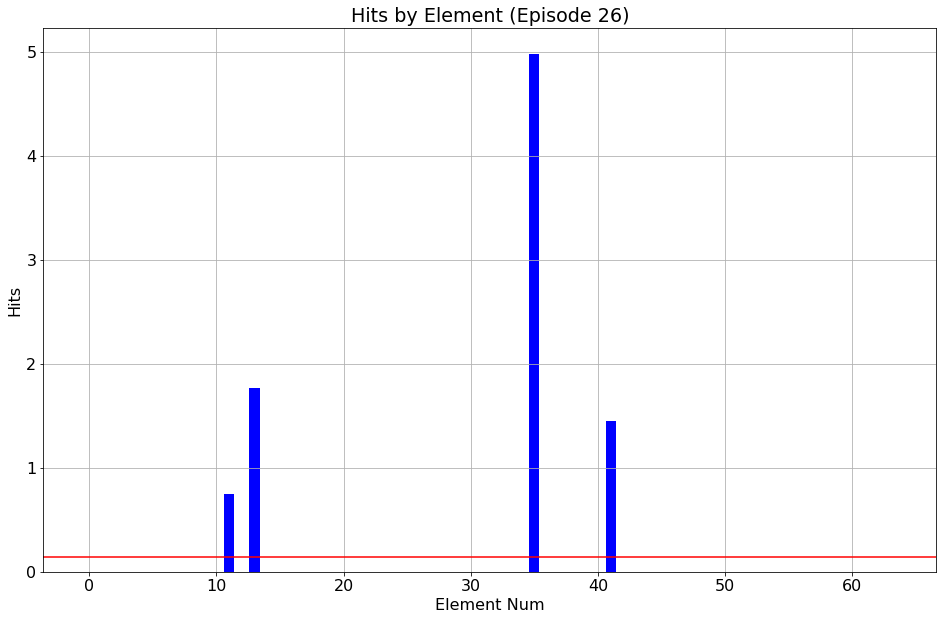


********************************************************************************
Round 8: 2048 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 26: Epoch  104, Batch   6656
effective_learning_rate=1.001e-04, training_time 268 sec.
Train on 4096 samples
Epoch 105/108
4096/4096 [==============================] - 4s 1ms/sample - loss: -1097.6248
Epoch 106/108
4096/4096 [==============================] - 2s 560us/sample - loss: -1123.4347
Epoch 107/108
4096/4096 [==============================] - 2s 565us/sample - loss: -1129.6880
Epoch 108/108
4096/4096 [==============================] - 2s 563us/sample - loss: -1135.7511
Adjusted element weight down on 64 candidate elements. Mean weight = 7.64e-03
Increasing bad_episode_count to 1.
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    246.27 :   246.27 :     

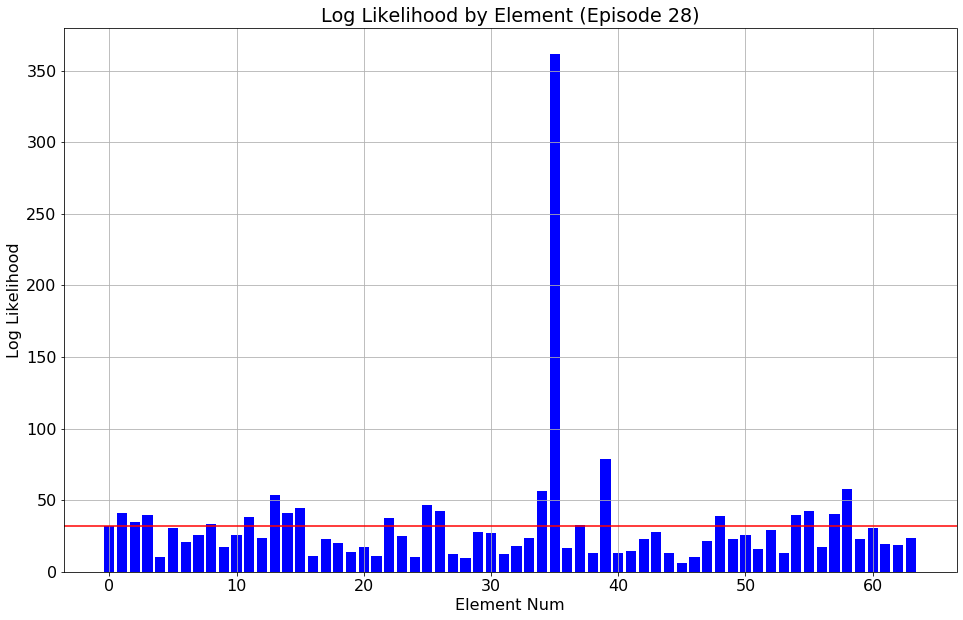

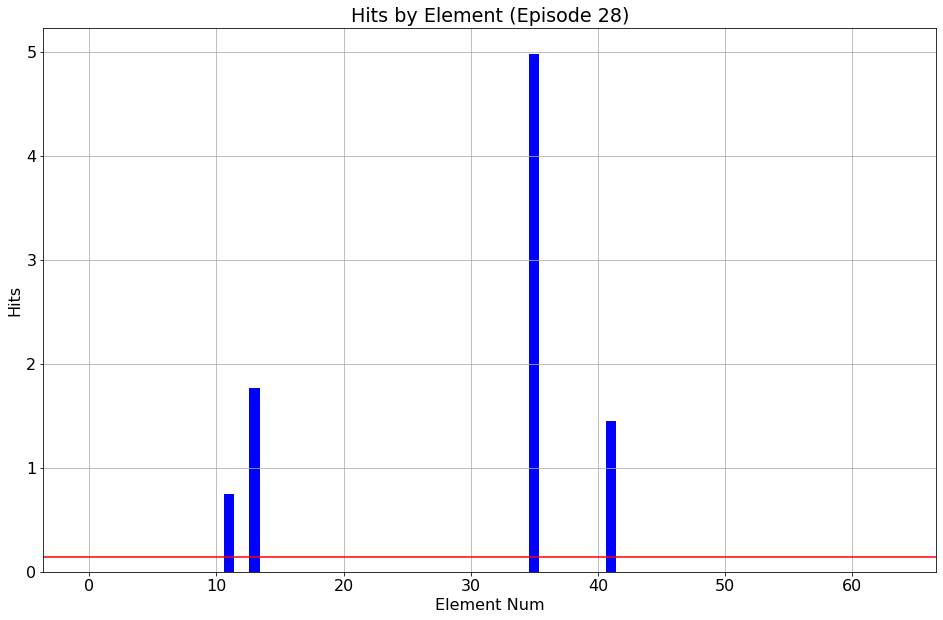


********************************************************************************
Round 9: 1024 batches @ LR 2^-13 in mixture mode.
********************************************************************************
Applying learning_rate 1.22e-04 (2.0^-13.0) for adaptive training.

Training episode 28: Epoch  112, Batch   7168
effective_learning_rate=1.221e-04, training_time 292 sec.
Train on 4096 samples
Epoch 113/116
4096/4096 [==============================] - 4s 856us/sample - loss: -532171230720.0000
Epoch 114/116
4096/4096 [==============================] - 2s 480us/sample - loss: -549828374016.0000
Epoch 115/116
4096/4096 [==============================] - 2s 485us/sample - loss: -567445703680.0000
Epoch 116/116
4096/4096 [==============================] - 2s 461us/sample - loss: -586773739520.0000
Adjusted element weight down on 62 candidate elements. Mean weight = 5.16e-01
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    244.86 :   244.86 :    

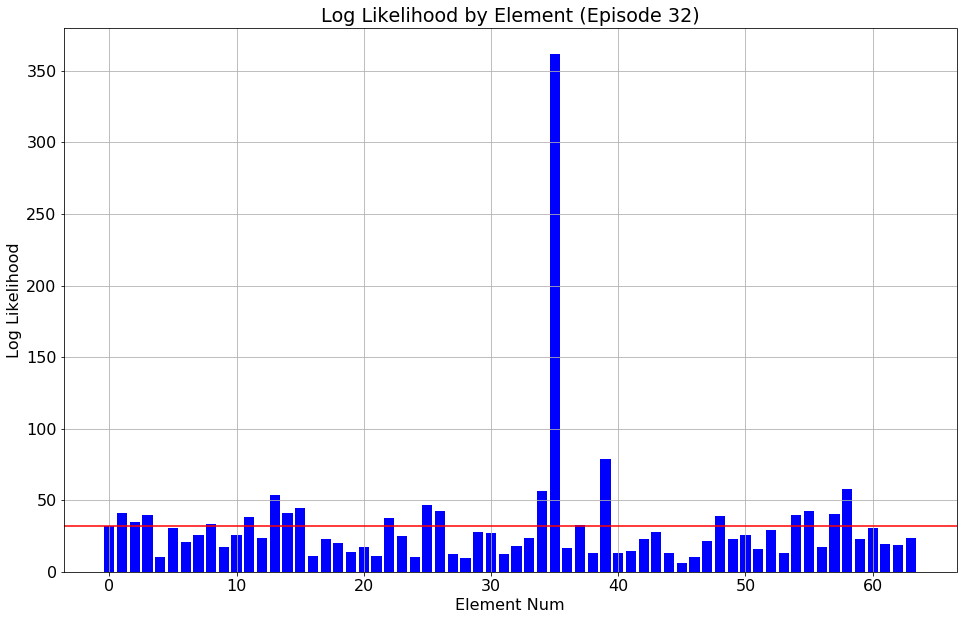

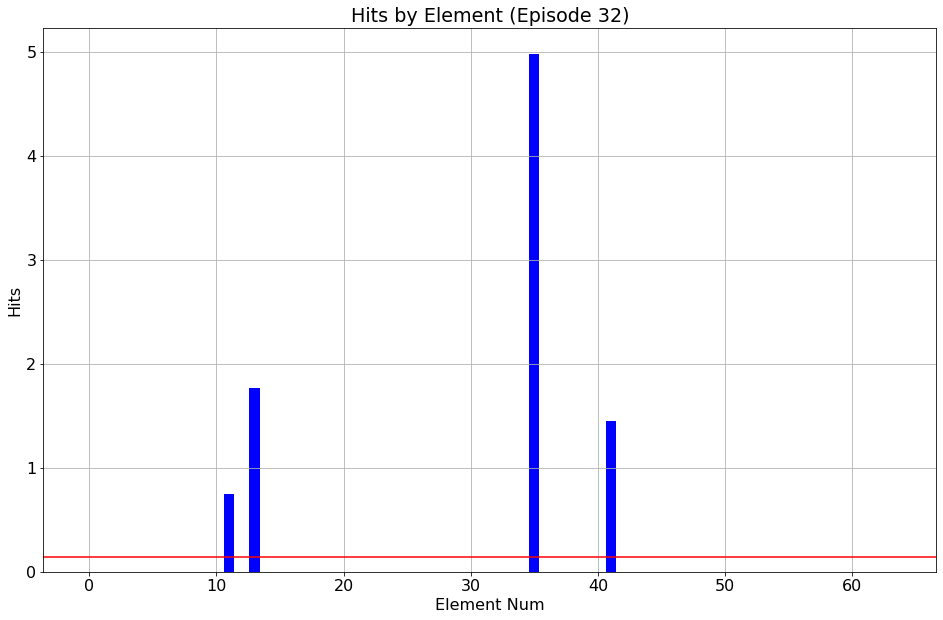


********************************************************************************
Round 10: 2048 batches @ LR 2^-18 in joint mode.
********************************************************************************
Applying learning_rate 3.81e-06 (2.0^-18.0) for adaptive training.

Training episode 32: Epoch  128, Batch   8192
effective_learning_rate=3.815e-06, training_time 329 sec.
Train on 4096 samples
Epoch 129/132
4096/4096 [==============================] - 5s 1ms/sample - loss: -2904634.8320
Epoch 130/132
4096/4096 [==============================] - 2s 586us/sample - loss: -2931659.2695
Epoch 131/132
4096/4096 [==============================] - 2s 598us/sample - loss: -2946815.2031
Epoch 132/132
4096/4096 [==============================] - 3s 614us/sample - loss: -2960810.4023
Adjusted element weight down on 64 candidate elements. Mean weight = 5.00e-01
Increasing bad_episode_count to 1.
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    242.85 :   

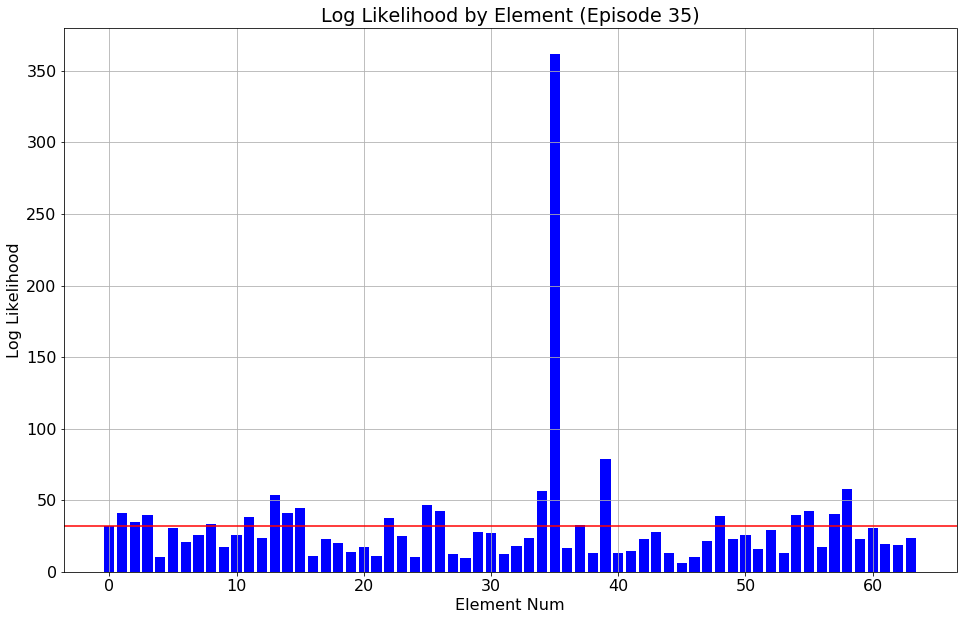

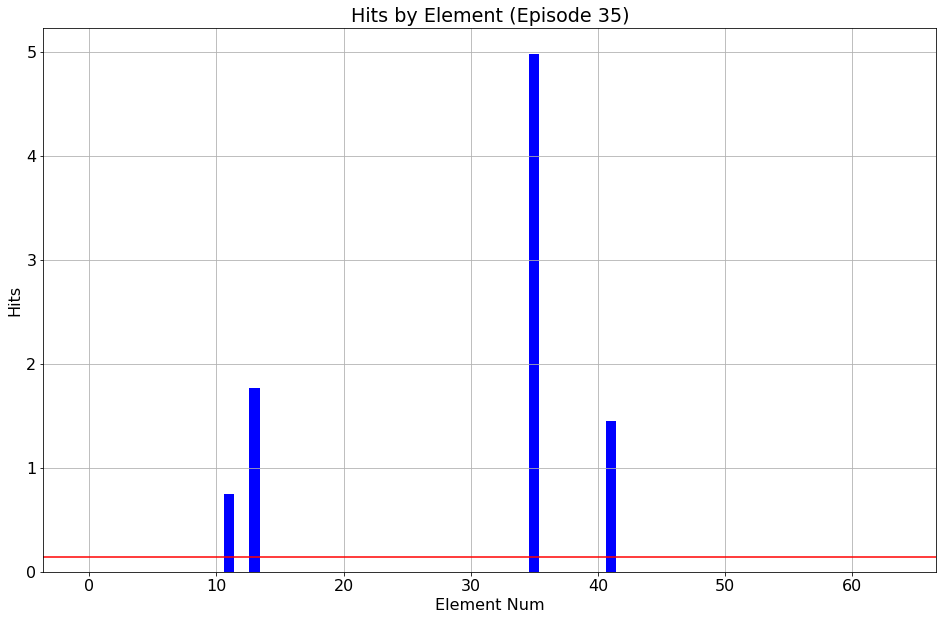


********************************************************************************
Round 11: 512 batches @ LR 2^-18 in joint mode.
********************************************************************************
Applying learning_rate 3.81e-06 (2.0^-18.0) for adaptive training.

Training episode 35: Epoch  140, Batch   8960
effective_learning_rate=3.815e-06, training_time 366 sec.
Train on 4096 samples
Epoch 141/144
4096/4096 [==============================] - 5s 1ms/sample - loss: -60308060288.0000
Epoch 142/144
4096/4096 [==============================] - 2s 605us/sample - loss: -60945678400.0000
Epoch 143/144
4096/4096 [==============================] - 2s 606us/sample - loss: -61334553088.0000
Epoch 144/144
4096/4096 [==============================] - 2s 601us/sample - loss: -61690863872.0000
Adjusted element weight down on 10 candidate elements. Mean weight = 9.22e-01
                    \  All Elts : Bad Elts : Good Elts (1)
Geom Mean Resolution:    241.38 :   249.78 :    28.00 ar

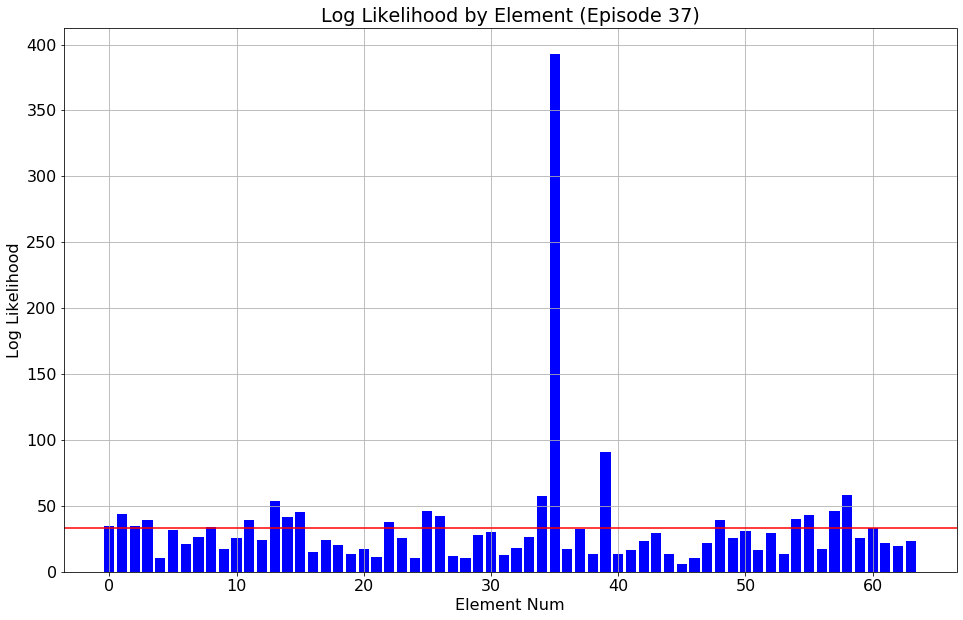

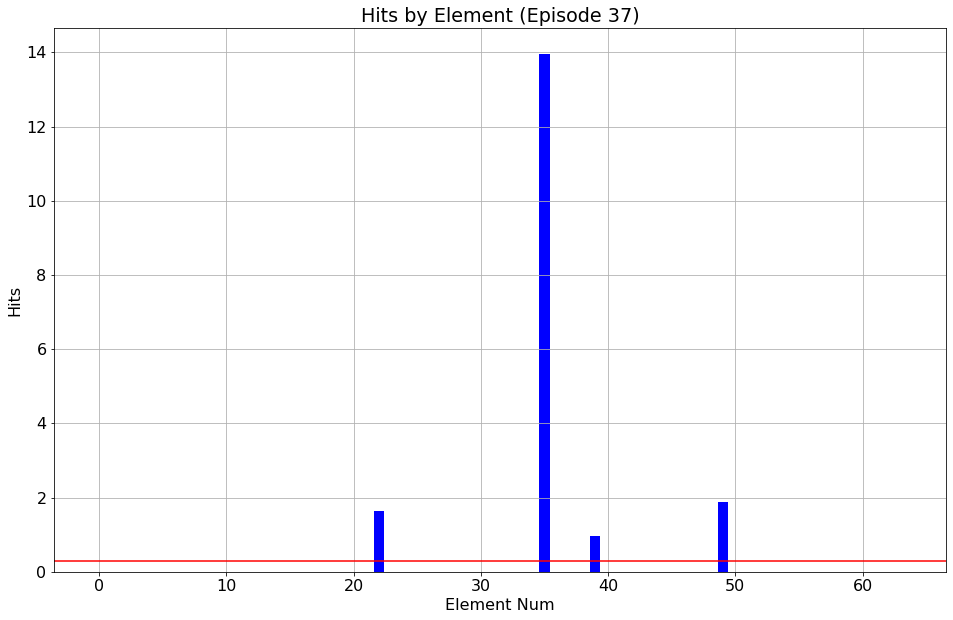

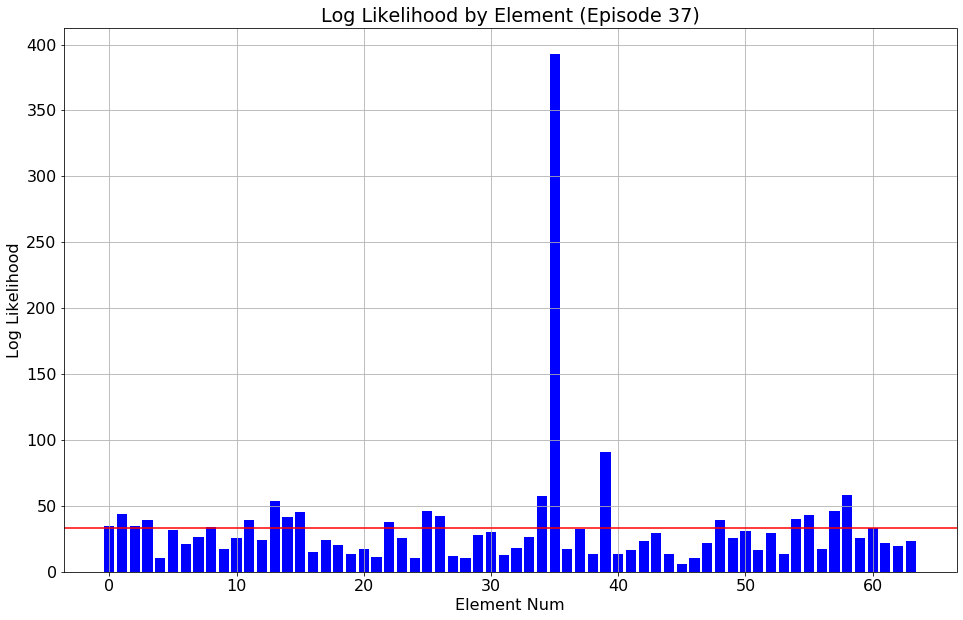

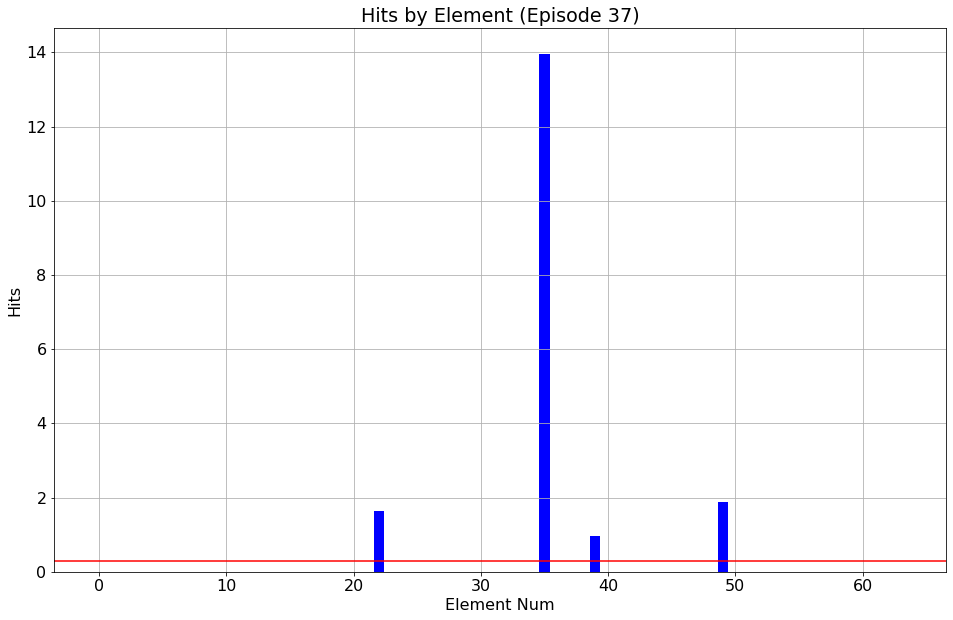

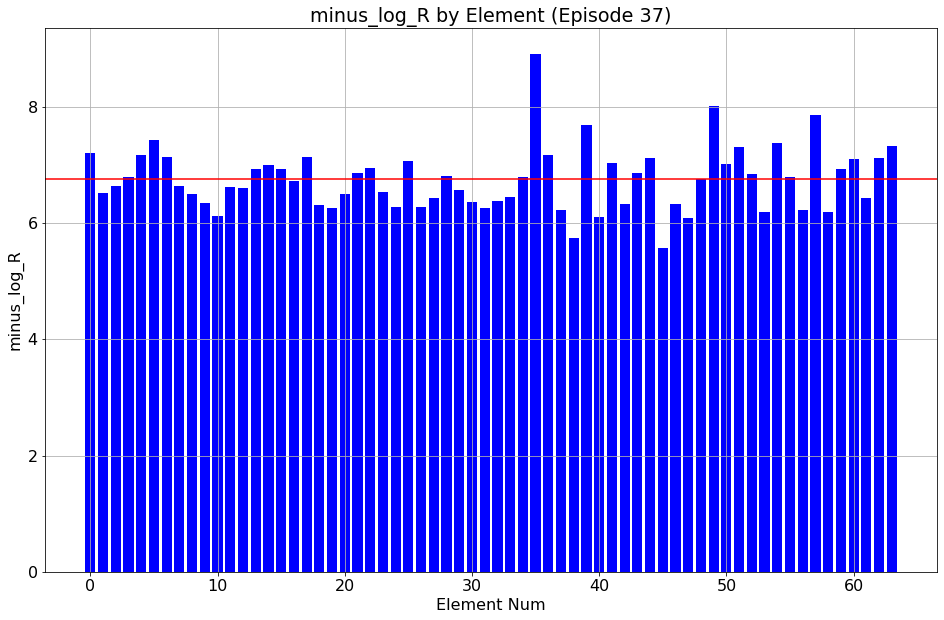

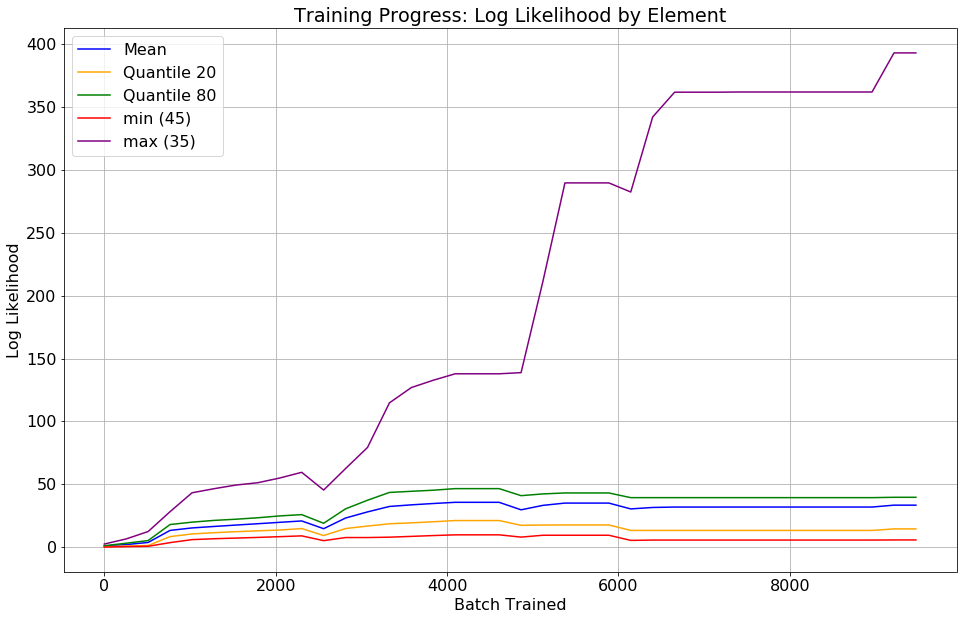

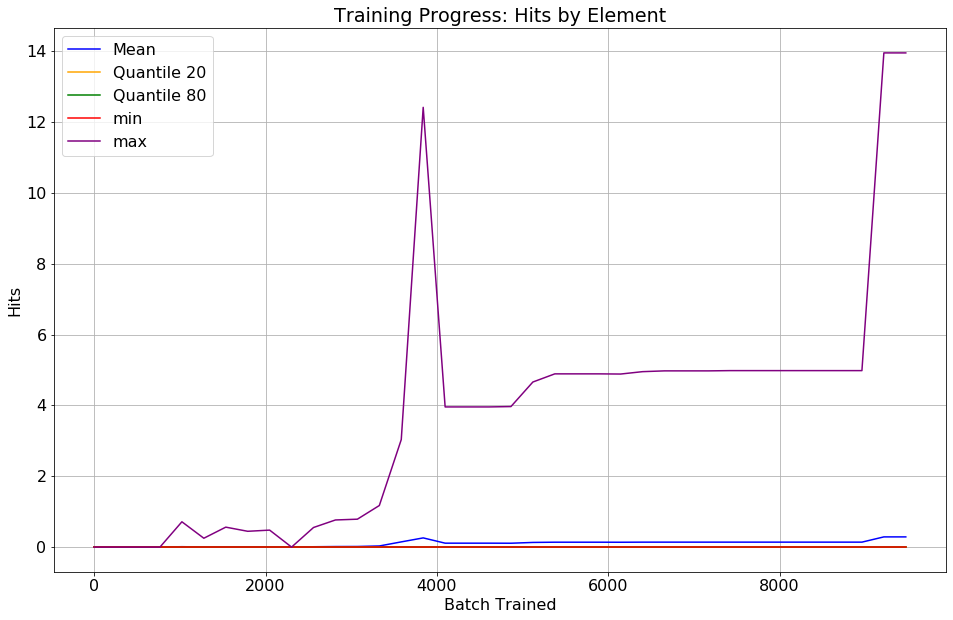

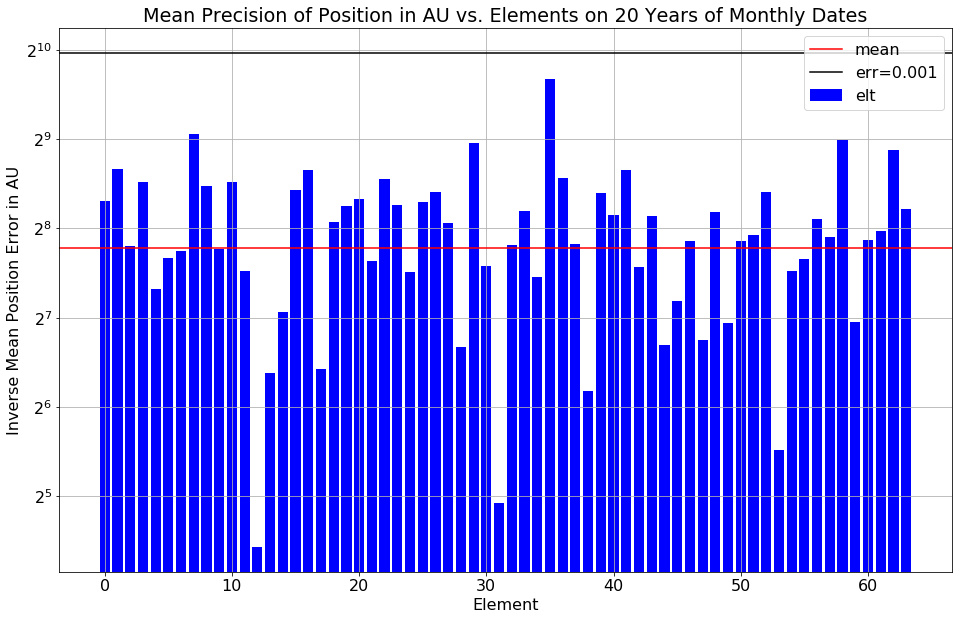

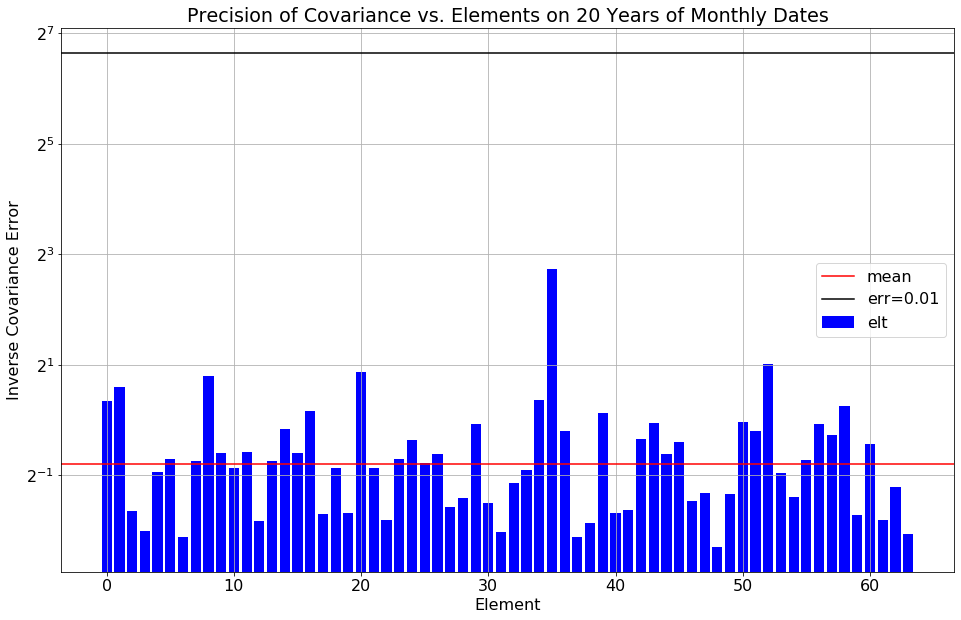

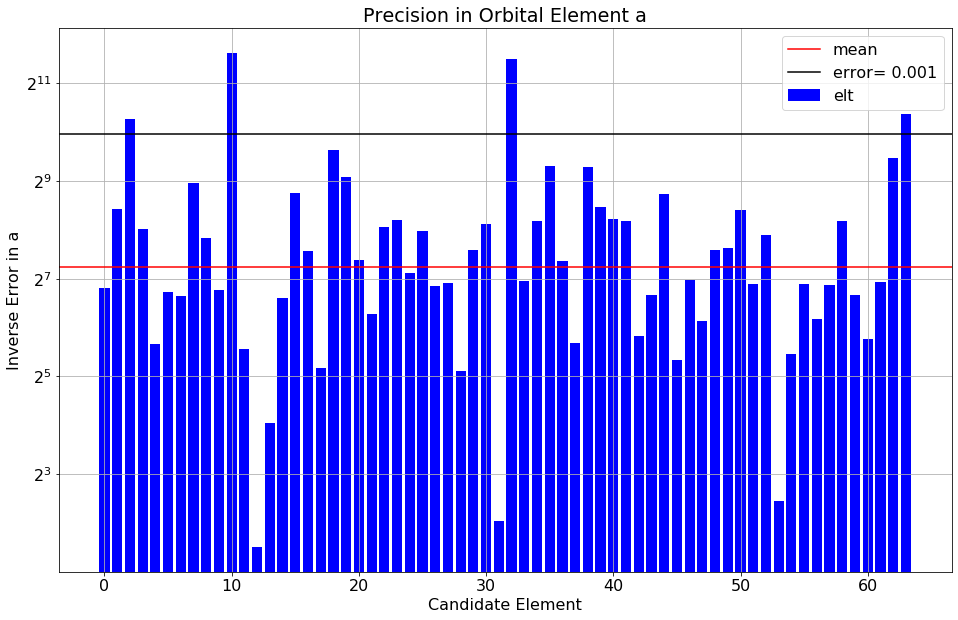

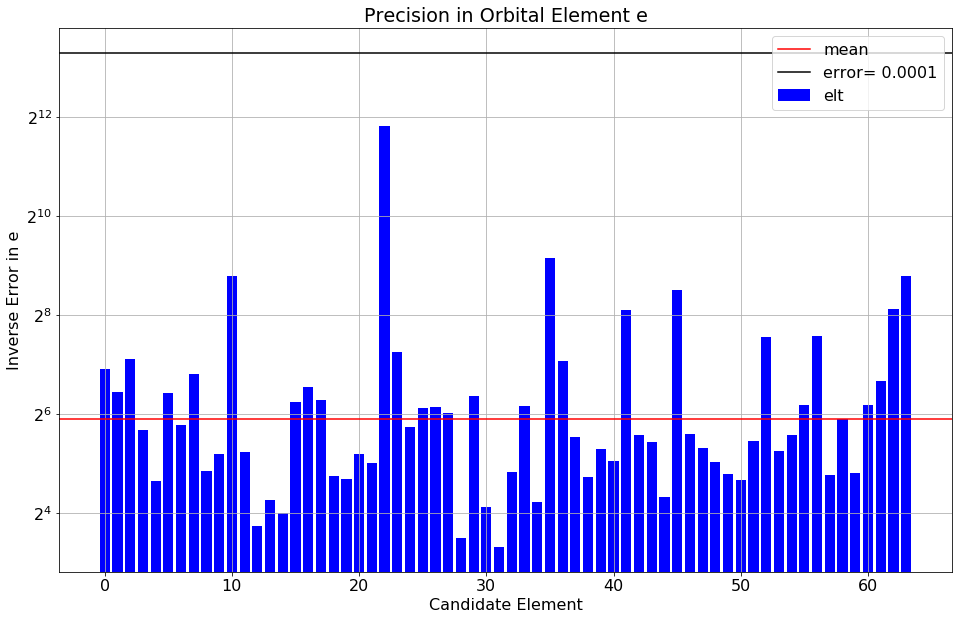

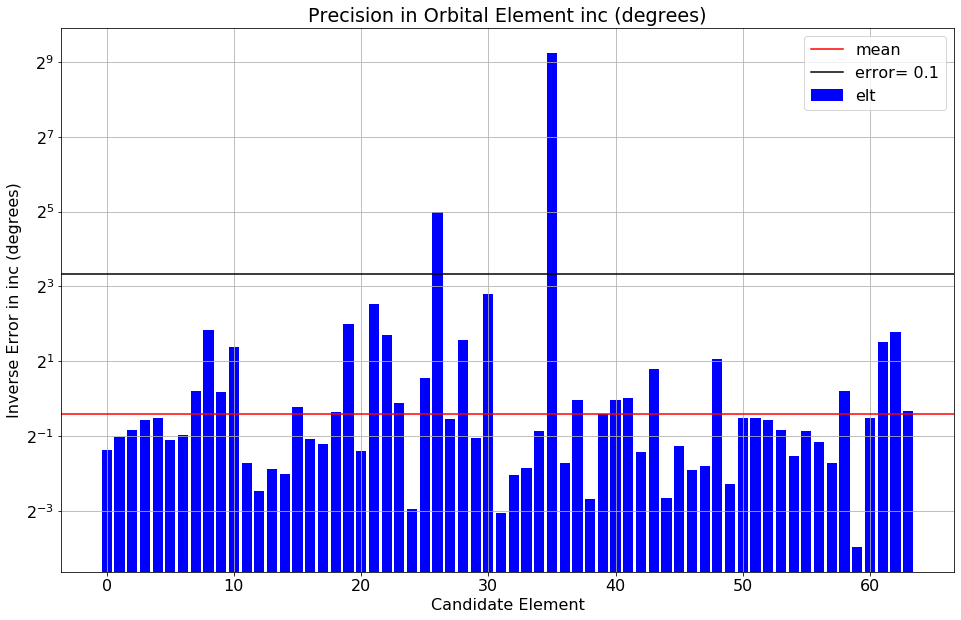

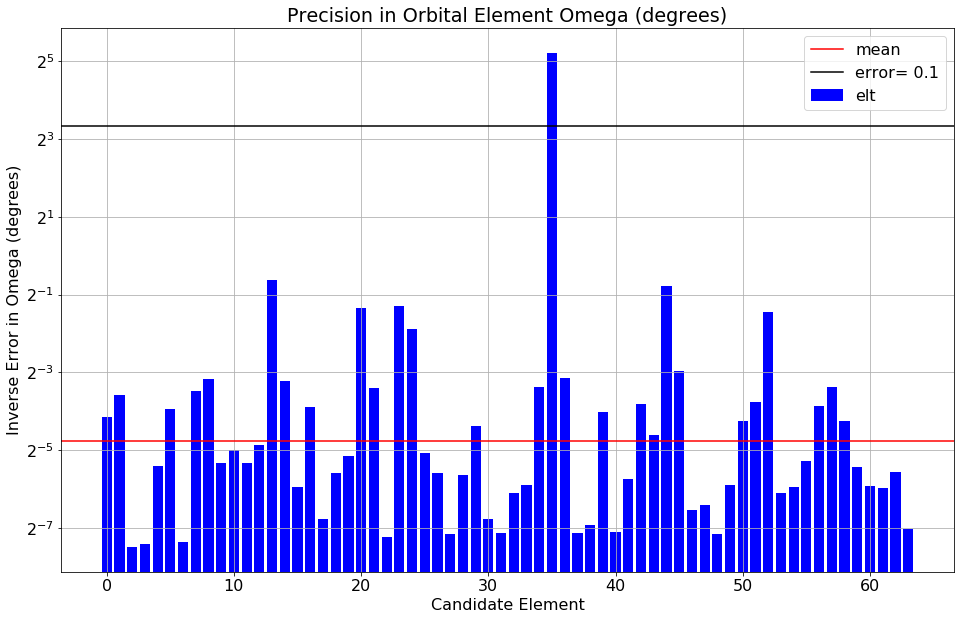

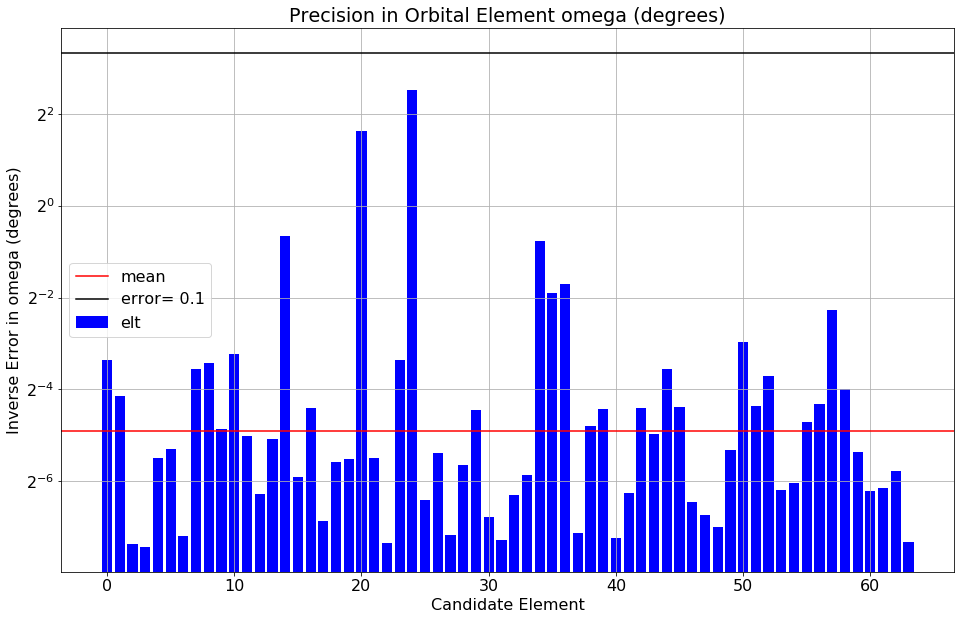

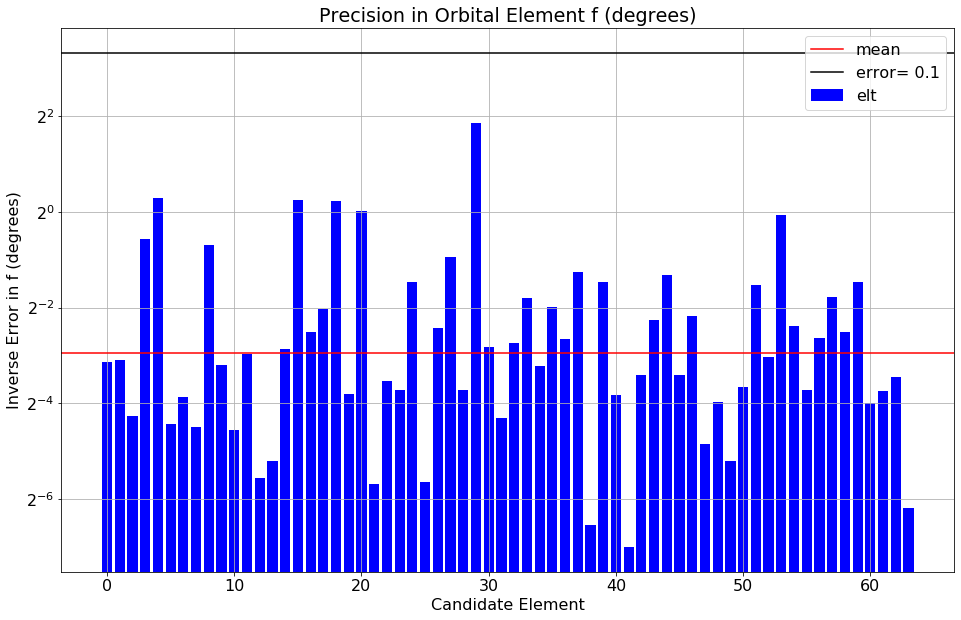

In [29]:
model.sieve(nearest_ast=True)

In [30]:
model.report()


Good elements (hits >= 10):   1.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:   392.76  :  14.00 :    28.00 :   939.16
Mean Bad :    27.84  :   0.08 :   278.36 :  2399.38
Mean     :    33.55  :   0.30 :   274.44 :  2376.56
Median   :    25.72  :   0.00 :   245.72 :  2400.00
GeoMean  :    25.40  :   0.09 :   241.59 :  2365.48
Min      :     5.92  :   0.00 :    28.00 :   939.16
Max      :   392.76  :  14.00 :   780.39 :  2400.00
Trained for 9472 batches over 148 epochs and 37 episodes (elapsed time 393 seconds).


## Review Results Graphically

In [31]:
# # Bar chart - log likelihood by element
# fig, ax = model.plot_bar('log_like', sorted=False)

In [32]:
# # Bar chart: hits
# fig, ax = model.plot_bar('hits', sorted=False)

In [33]:
# # Bar chart: log likelihood
# fig, ax = model.plot_bar('R_deg', sorted=False)

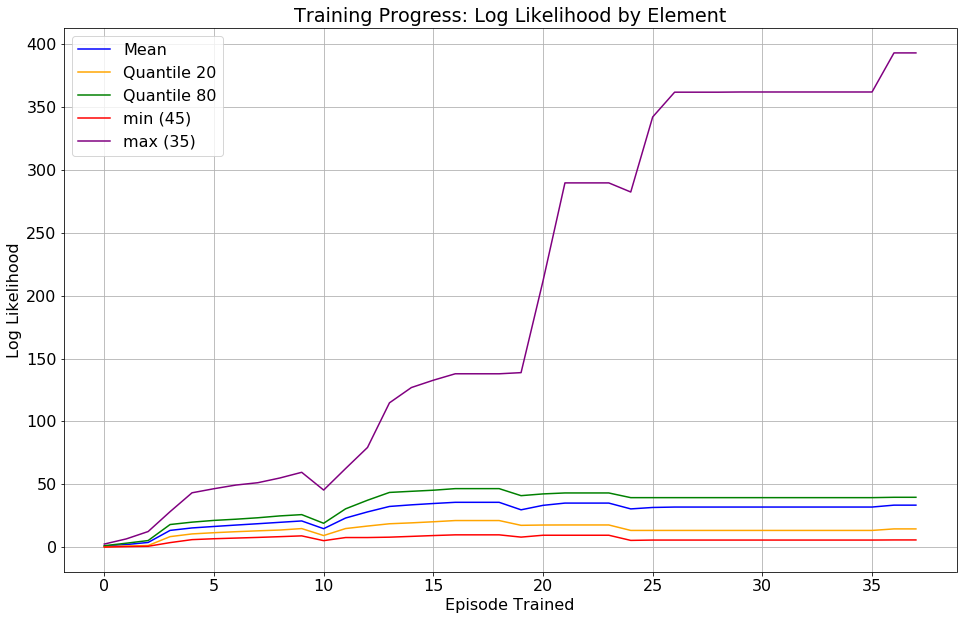

In [34]:
# Learning curve: log likelihood
fig, ax = model.plot_hist('log_like', 'episode')

In [35]:
# # Learning curve: hits
# fig, ax = model.plot_hist('hits')

## Distance vs. Nearest Asteroid for Fitted Elements

In [36]:
# Find nearest asteroid to fitted elements - search on Cartesian distance
elts_fit, elts_near = model.nearest_ast(search_type='cart')

In [37]:
elts_fit

,element_id,a,e,inc,Omega,omega,f,epoch,num_hits,R,...,thresh_deg,thresh_sec,log_like,hits,num_rows_close,H,sigma_mag,nearest_ast_num,nearest_ast_dist,nearest_ast_q_norm
0,0,2.985729,0.103673,0.068221,0.657129,0.937459,-1.308390,58600.0,58.528370,0.000742,...,0.666667,2399.999756,34.534634,0.0,1869.0,16.500002,1.0,1012289,0.003150,0.786631
1,1,2.747478,0.157139,0.066649,1.344562,6.104362,-0.540693,58600.0,110.308388,0.001474,...,0.666667,2399.999756,43.479988,0.0,1517.0,16.500002,1.0,409558,0.002461,0.656662
2,2,2.965839,0.088757,0.047576,3.960976,0.680927,1.889135,58600.0,101.553543,0.001324,...,0.666667,2399.999756,34.450153,0.0,1810.0,16.500002,1.0,44369,0.004482,3.127444
3,3,2.761339,0.121852,0.013335,1.628783,5.299962,0.061840,58600.0,84.043335,0.001126,...,0.666667,2399.999756,39.399181,0.0,1384.0,16.500002,1.0,1164560,0.002715,4.006129
4,4,3.102610,0.247820,0.089208,0.084203,4.328811,2.604264,58600.0,25.067810,0.000769,...,0.666667,2399.999756,10.567403,0.0,1139.0,16.500002,1.0,199771,0.006268,1.924480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,59,1.881619,0.090675,0.040313,0.683317,3.235447,3.123223,58600.0,51.983086,0.000978,...,0.666667,2399.999756,25.298767,0.0,1274.0,16.500002,1.0,1179500,0.008099,3.296088
60,60,3.176636,0.083628,0.049724,5.191022,0.895669,0.855818,58600.0,55.491104,0.000821,...,0.666667,2399.999756,33.299599,0.0,1451.0,16.500002,1.0,462127,0.004266,1.356054
61,61,2.430813,0.071189,0.069360,4.741338,1.913965,-1.096436,58600.0,64.659470,0.001624,...,0.666667,2399.999756,21.502575,0.0,889.0,16.500002,1.0,193192,0.003970,3.513715
62,62,2.322000,0.181705,0.047961,3.276161,2.243142,-0.596884,58600.0,28.833664,0.000815,...,0.666667,2399.999756,19.654129,0.0,582.0,16.500002,1.0,187111,0.002128,2.308083


In [38]:
# Review asteroids nearest to the fitted elements
cols = ['element_id', 'log_like', 'hits', 'R_sec', 'thresh_sec', 'nearest_ast_num', 'nearest_ast_dist', 'nearest_ast_q_norm']

# Summary
has_hits = (model.elts_fit.hits >= 10)
is_converged = has_hits
num_converged = np.sum(is_converged)

# Mean on converged
mean_hits = np.mean(model.elts_fit.hits[is_converged])
mean_R_sec = np.mean(model.elts_fit.R_sec[is_converged])
err_cart_mean = np.mean(model.elts_near_ast.nearest_ast_dist[is_converged])
err_cart_geo = np.exp(np.mean(np.log(model.elts_near_ast.nearest_ast_dist[is_converged])))
err_cov_mean = np.exp(np.mean(np.log(model.elts_near_ast.nearest_ast_q_norm[is_converged])))

# Report
print(f'Good convergence on {num_converged} asteroids.')
print(f'Mean on converged asteroids:')
print(f'Number of hits         : {mean_hits:5.2f}')
print(f'Resolution in arc sec  : {mean_R_sec:5.2f}')
# print(f'Mean Distance in AU    : {err_cart_mean:5.2e}')
print(f'GeoMean Distance in AU : {err_cart_geo:5.2e}')
print(f'Covariance norm        : {err_cov_mean:5.2e}')

Good convergence on 1 asteroids.
Mean on converged asteroids:
Number of hits         : 13.95
Resolution in arc sec  : 28.00
GeoMean Distance in AU : 1.22e-03
Covariance norm        : 1.51e-01


In [39]:
# Review good matches
model.elts_fit[cols][is_converged].sort_values(by=['hits', 'R_sec'], ascending=[False, True])

,element_id,log_like,hits,R_sec,thresh_sec,nearest_ast_num,nearest_ast_dist,nearest_ast_q_norm
35,35,392.75827,13.95243,28.003284,939.160278,49846,0.001224,0.150611


In [40]:
# # Filter for incomplete convergence
# mask = (elts_fit.log_like > 200) & (elts_fit.R_sec >= 60)
# elts_fit[mask]

## Visualize Error vs. Nearest Asteroid

In [41]:
# model.elts_near_ast

In [42]:
model.elts_fit

,element_id,a,e,inc,Omega,omega,f,epoch,num_hits,R,...,thresh_deg,thresh_sec,log_like,hits,num_rows_close,H,sigma_mag,nearest_ast_num,nearest_ast_dist,nearest_ast_q_norm
0,0,2.985729,0.103673,0.068221,0.657129,0.937459,-1.308390,58600.0,58.528370,0.000742,...,0.666667,2399.999756,34.534634,0.0,1869.0,16.500002,1.0,1012289,0.003150,0.786631
1,1,2.747478,0.157139,0.066649,1.344562,6.104362,-0.540693,58600.0,110.308388,0.001474,...,0.666667,2399.999756,43.479988,0.0,1517.0,16.500002,1.0,409558,0.002461,0.656662
2,2,2.965839,0.088757,0.047576,3.960976,0.680927,1.889135,58600.0,101.553543,0.001324,...,0.666667,2399.999756,34.450153,0.0,1810.0,16.500002,1.0,44369,0.004482,3.127444
3,3,2.761339,0.121852,0.013335,1.628783,5.299962,0.061840,58600.0,84.043335,0.001126,...,0.666667,2399.999756,39.399181,0.0,1384.0,16.500002,1.0,1164560,0.002715,4.006129
4,4,3.102610,0.247820,0.089208,0.084203,4.328811,2.604264,58600.0,25.067810,0.000769,...,0.666667,2399.999756,10.567403,0.0,1139.0,16.500002,1.0,199771,0.006268,1.924480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,59,1.881619,0.090675,0.040313,0.683317,3.235447,3.123223,58600.0,51.983086,0.000978,...,0.666667,2399.999756,25.298767,0.0,1274.0,16.500002,1.0,1179500,0.008099,3.296088
60,60,3.176636,0.083628,0.049724,5.191022,0.895669,0.855818,58600.0,55.491104,0.000821,...,0.666667,2399.999756,33.299599,0.0,1451.0,16.500002,1.0,462127,0.004266,1.356054
61,61,2.430813,0.071189,0.069360,4.741338,1.913965,-1.096436,58600.0,64.659470,0.001624,...,0.666667,2399.999756,21.502575,0.0,889.0,16.500002,1.0,193192,0.003970,3.513715
62,62,2.322000,0.181705,0.047961,3.276161,2.243142,-0.596884,58600.0,28.833664,0.000815,...,0.666667,2399.999756,19.654129,0.0,582.0,16.500002,1.0,187111,0.002128,2.308083


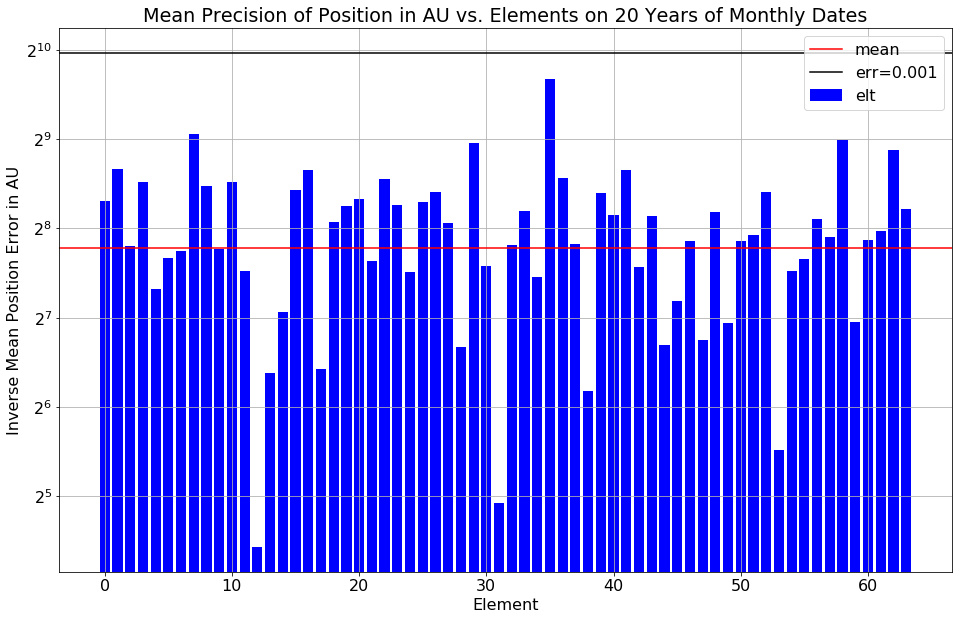

In [43]:
# Plot position error vs. known elements
fig, ax = model.plot_q_error(is_log=True, use_near_ast_dist=True)

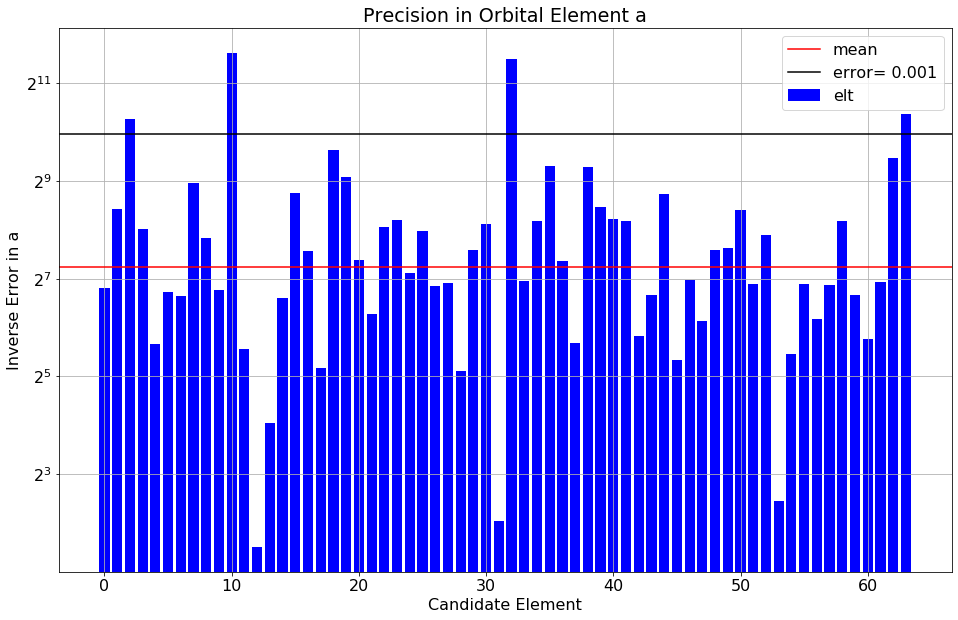

In [44]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='a', is_log=True)

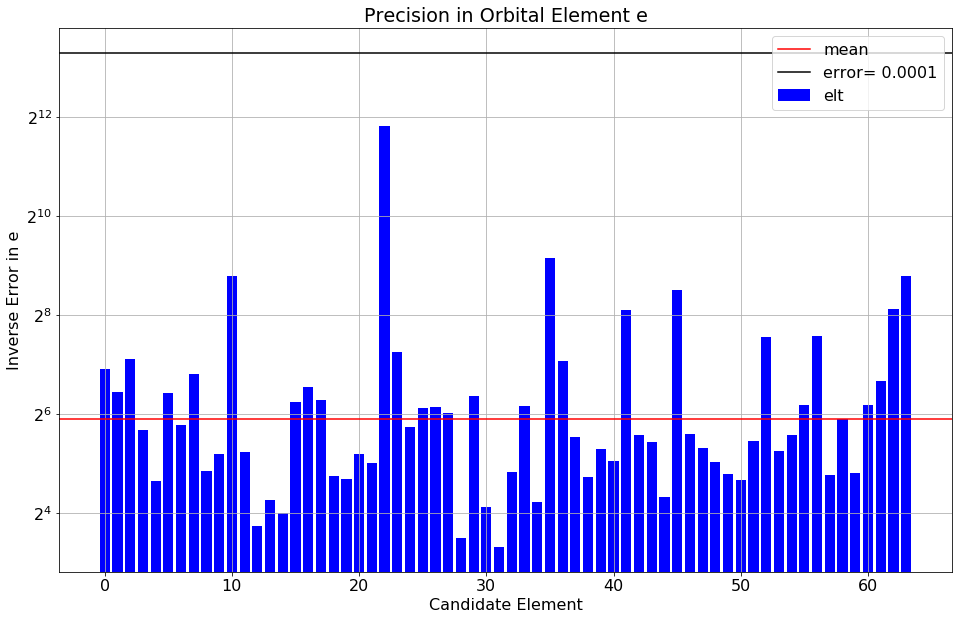

In [45]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='e', is_log=True)